In [22]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%run /home/datarian/git/master-thesis-code/notebooks/common_init.ipynb

Setup logging to file: out.log
Figure output directory saved in figure_output at /home/datarian/OneDrive/unine/Master_Thesis/ma-thesis-report/figures


In [24]:
%run /home/datarian/git/master-thesis-code/notebooks/learning_init.ipynb

Set plot_confusion_matrix()


In [25]:
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_palette("husl")

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config
from kdd98.transformers import Rescaler
import pathlib
import pickle

In [26]:
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [27]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import ParameterGrid, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_recall_curve, make_scorer, log_loss, precision_score, recall_score, auc, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from glmnet import LogitNet
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin

In [28]:
# Where to save the figures

CHAPTER_ID = "model_selection"
# Where to save the figures
IMAGES_PATH = pathlib.Path(figure_output, CHAPTER_ID)

pathlib.Path(IMAGES_PATH).mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension=["pdf", "png"], resolution=300):
    if tight_layout:
        plt.tight_layout()
    [plt.savefig(pathlib.Path(IMAGES_PATH, fig_id + "." + f), 
                 format=f,
                 dpi=resolution,
                 transparent=True,
                 bbox_inches='tight') for f in fig_extension]

In [28]:
with open(pathlib.Path(Config.get("df_store"), "X_train.pd.pkl"), "rb") as f:
    kdd98_learn_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_train.pd.pkl"), "rb") as f:
    kdd98_learn_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_test.pd.pkl"), "rb") as f:
    kdd98_test_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_test.pd.pkl"), "rb") as f:
    kdd98_test_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_train_all_relevant.pd.pkl"), "rb") as f:
    kdd98_learn_feat_all_relevant = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_test_all_relevant.pd.pkl"), "rb") as f:
    kdd98_test_feat_all_relevant = pickle.load(f)
    
# Extracting the data and resetting target to [-1, 1]
X_train = kdd98_learn_feat.values
X_train_all_relevant = kdd98_learn_feat_all_relevant.values
y_train = kdd98_learn_targets.loc[:,"TARGET_B"].astype("int64").values

X_test = kdd98_test_feat.values
X_test_all_relevant = kdd98_test_feat_all_relevant.values
y_test = kdd98_test_targets.loc[:,"TARGET_B"].astype("int64").values

In [68]:
result_store = pathlib.Path(
    Config.get("model_store"), "gridsearch_results_dict.pkl")

with open(result_store, "rb") as f:
    gridsearch_results = pickle.load(f)

In [30]:
pathlib.Path(Config.get("model_store"), "gridsearch_GBM.pkl")

PosixPath('/data/home/datarian/git/master-thesis-code/models/gridsearch_GBM.pkl')

In [31]:
with open(pathlib.Path(Config.get("model_store"), "gridsearch_GBM.pkl"), "rb") as f:
    gbm_results = pickle.load(f) 

In [32]:
gbm_results.best_params_

{'classifier__colsample_bytree': 0.5505199419576297,
 'classifier__learning_rate': 0.10393774484000626,
 'classifier__max_delta_step': 4,
 'classifier__max_depth': 4,
 'sampler': None}

# Predictions 

## Confusion Matrices

Normalized confusion matrix
[[0.14447884 0.85552116]
 [0.01617533 0.98382467]]
Normalized confusion matrix
[[0.55727554 0.44272446]
 [0.28988628 0.71011372]]
Normalized confusion matrix
[[0.25386997 0.74613003]
 [0.10406316 0.89593684]]
Normalized confusion matrix
[[0.29308566 0.70691434]
 [0.11874793 0.88125207]]


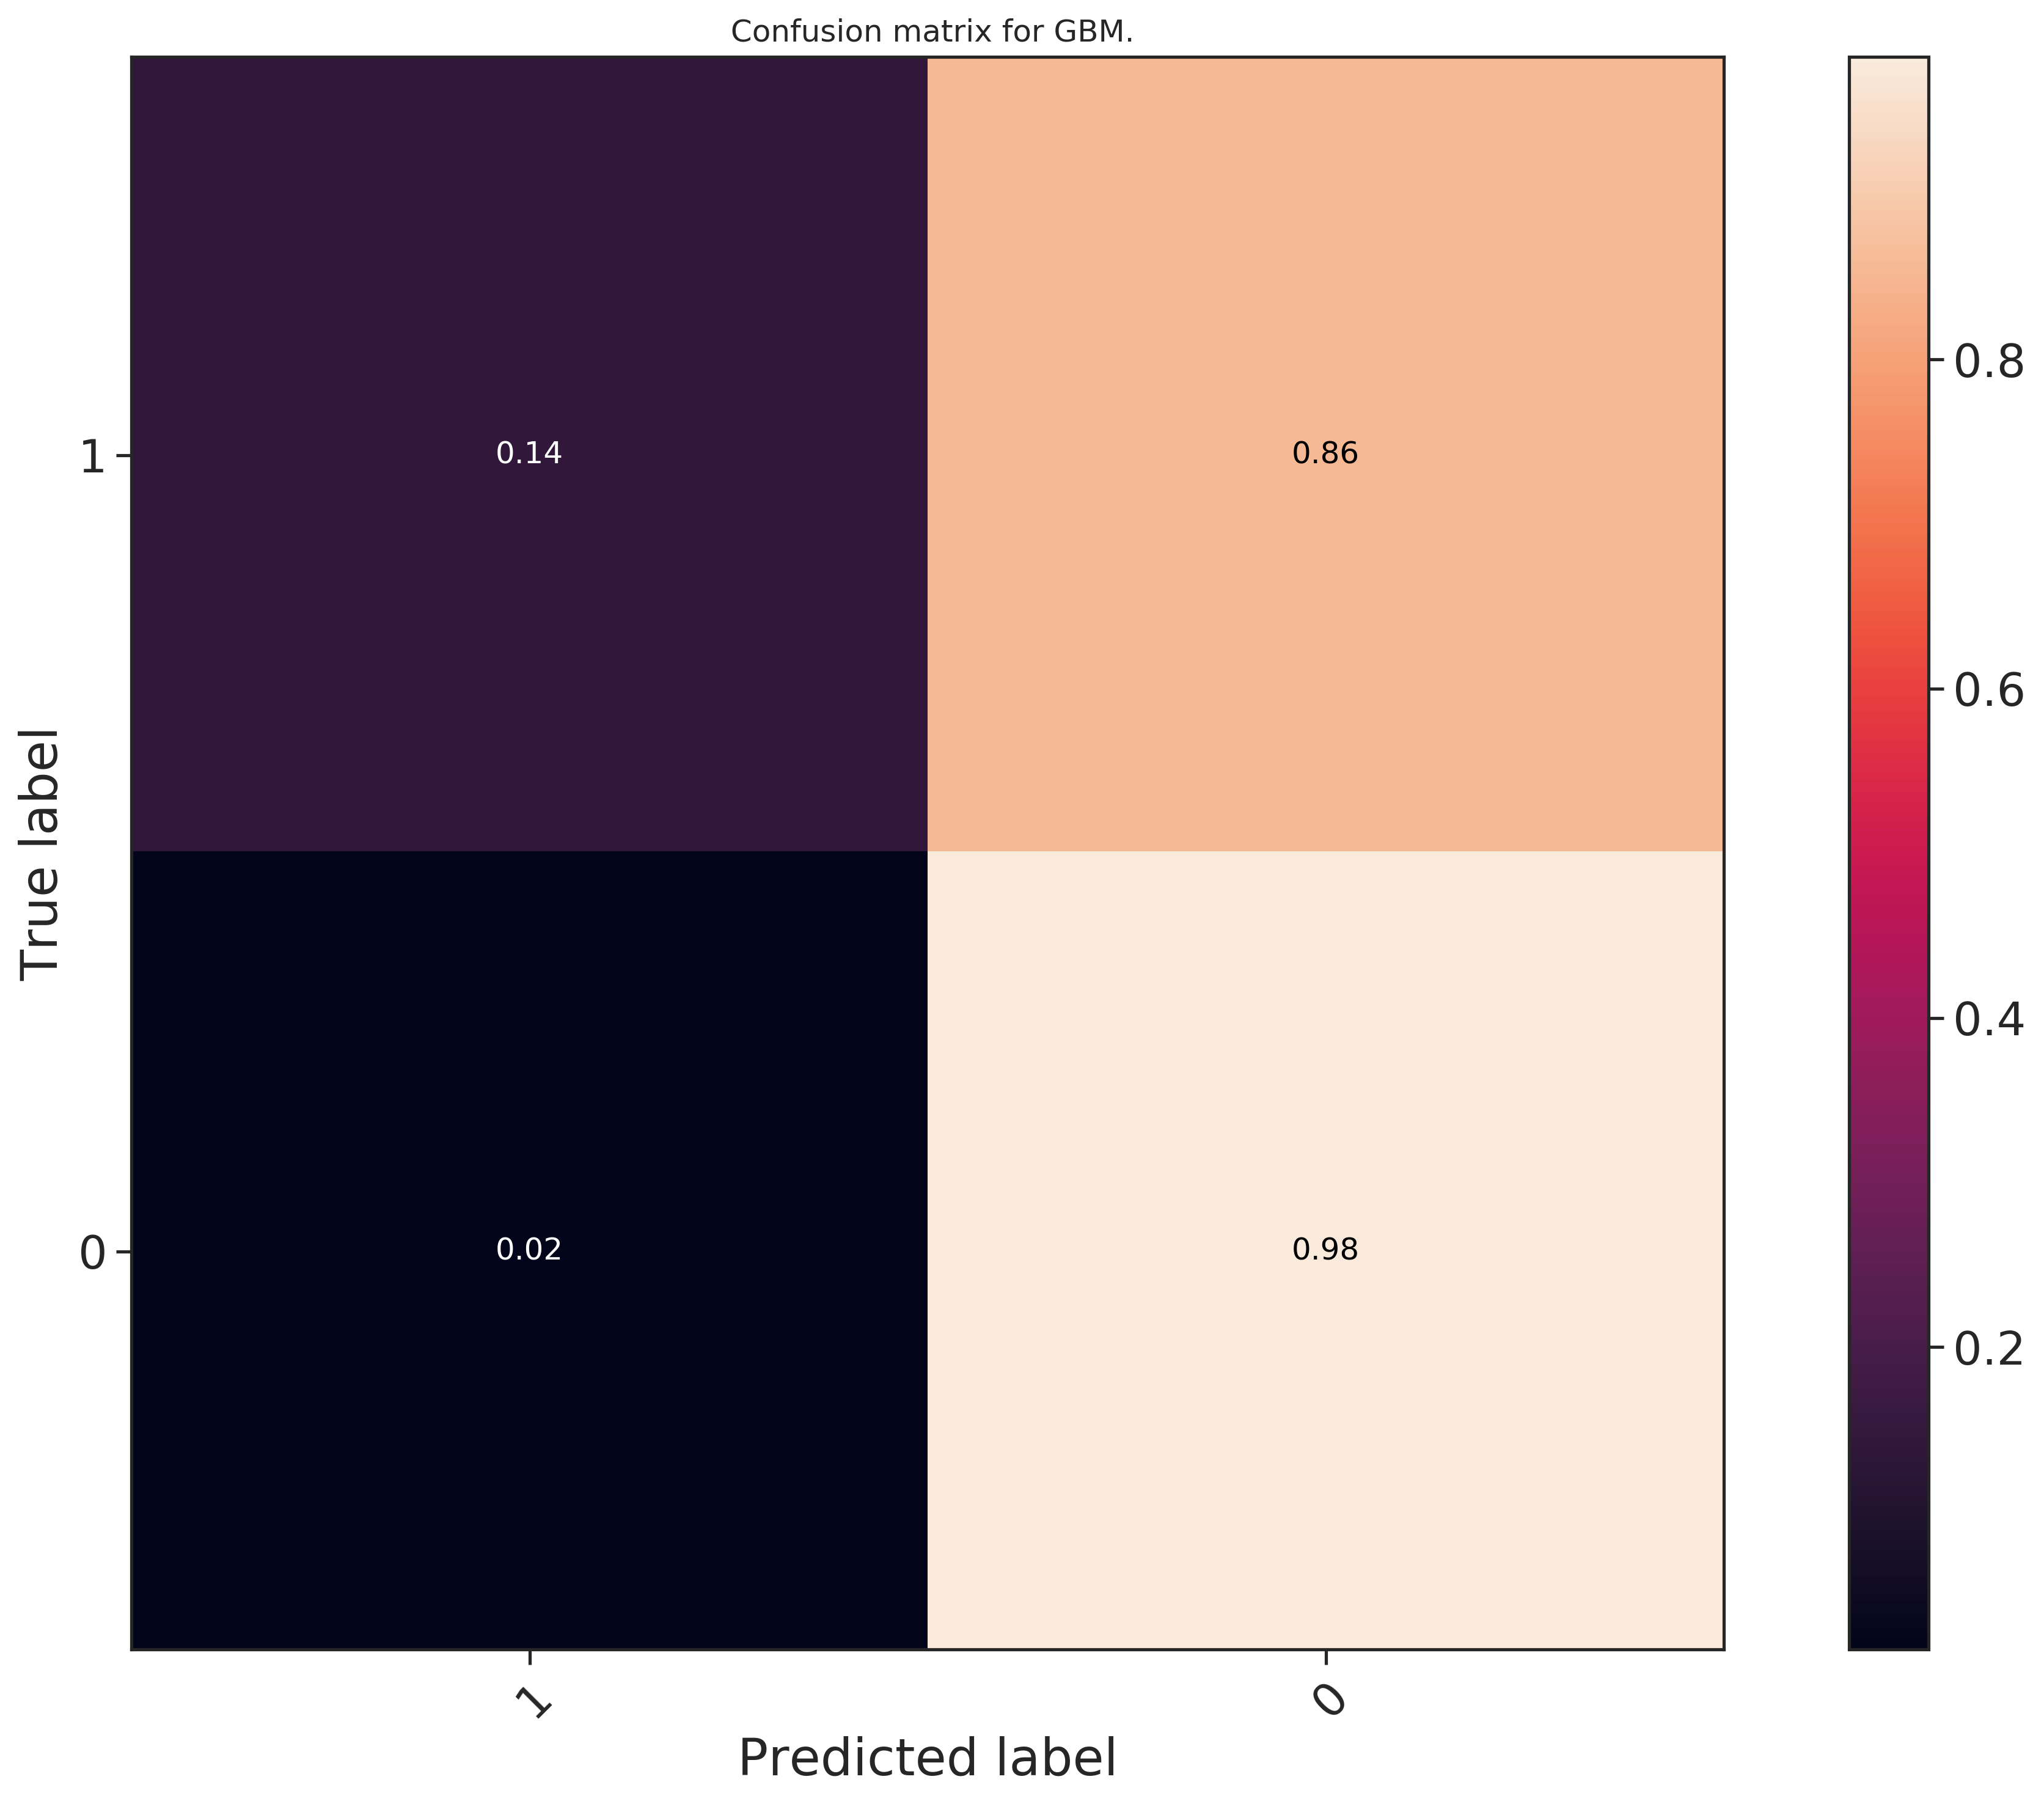

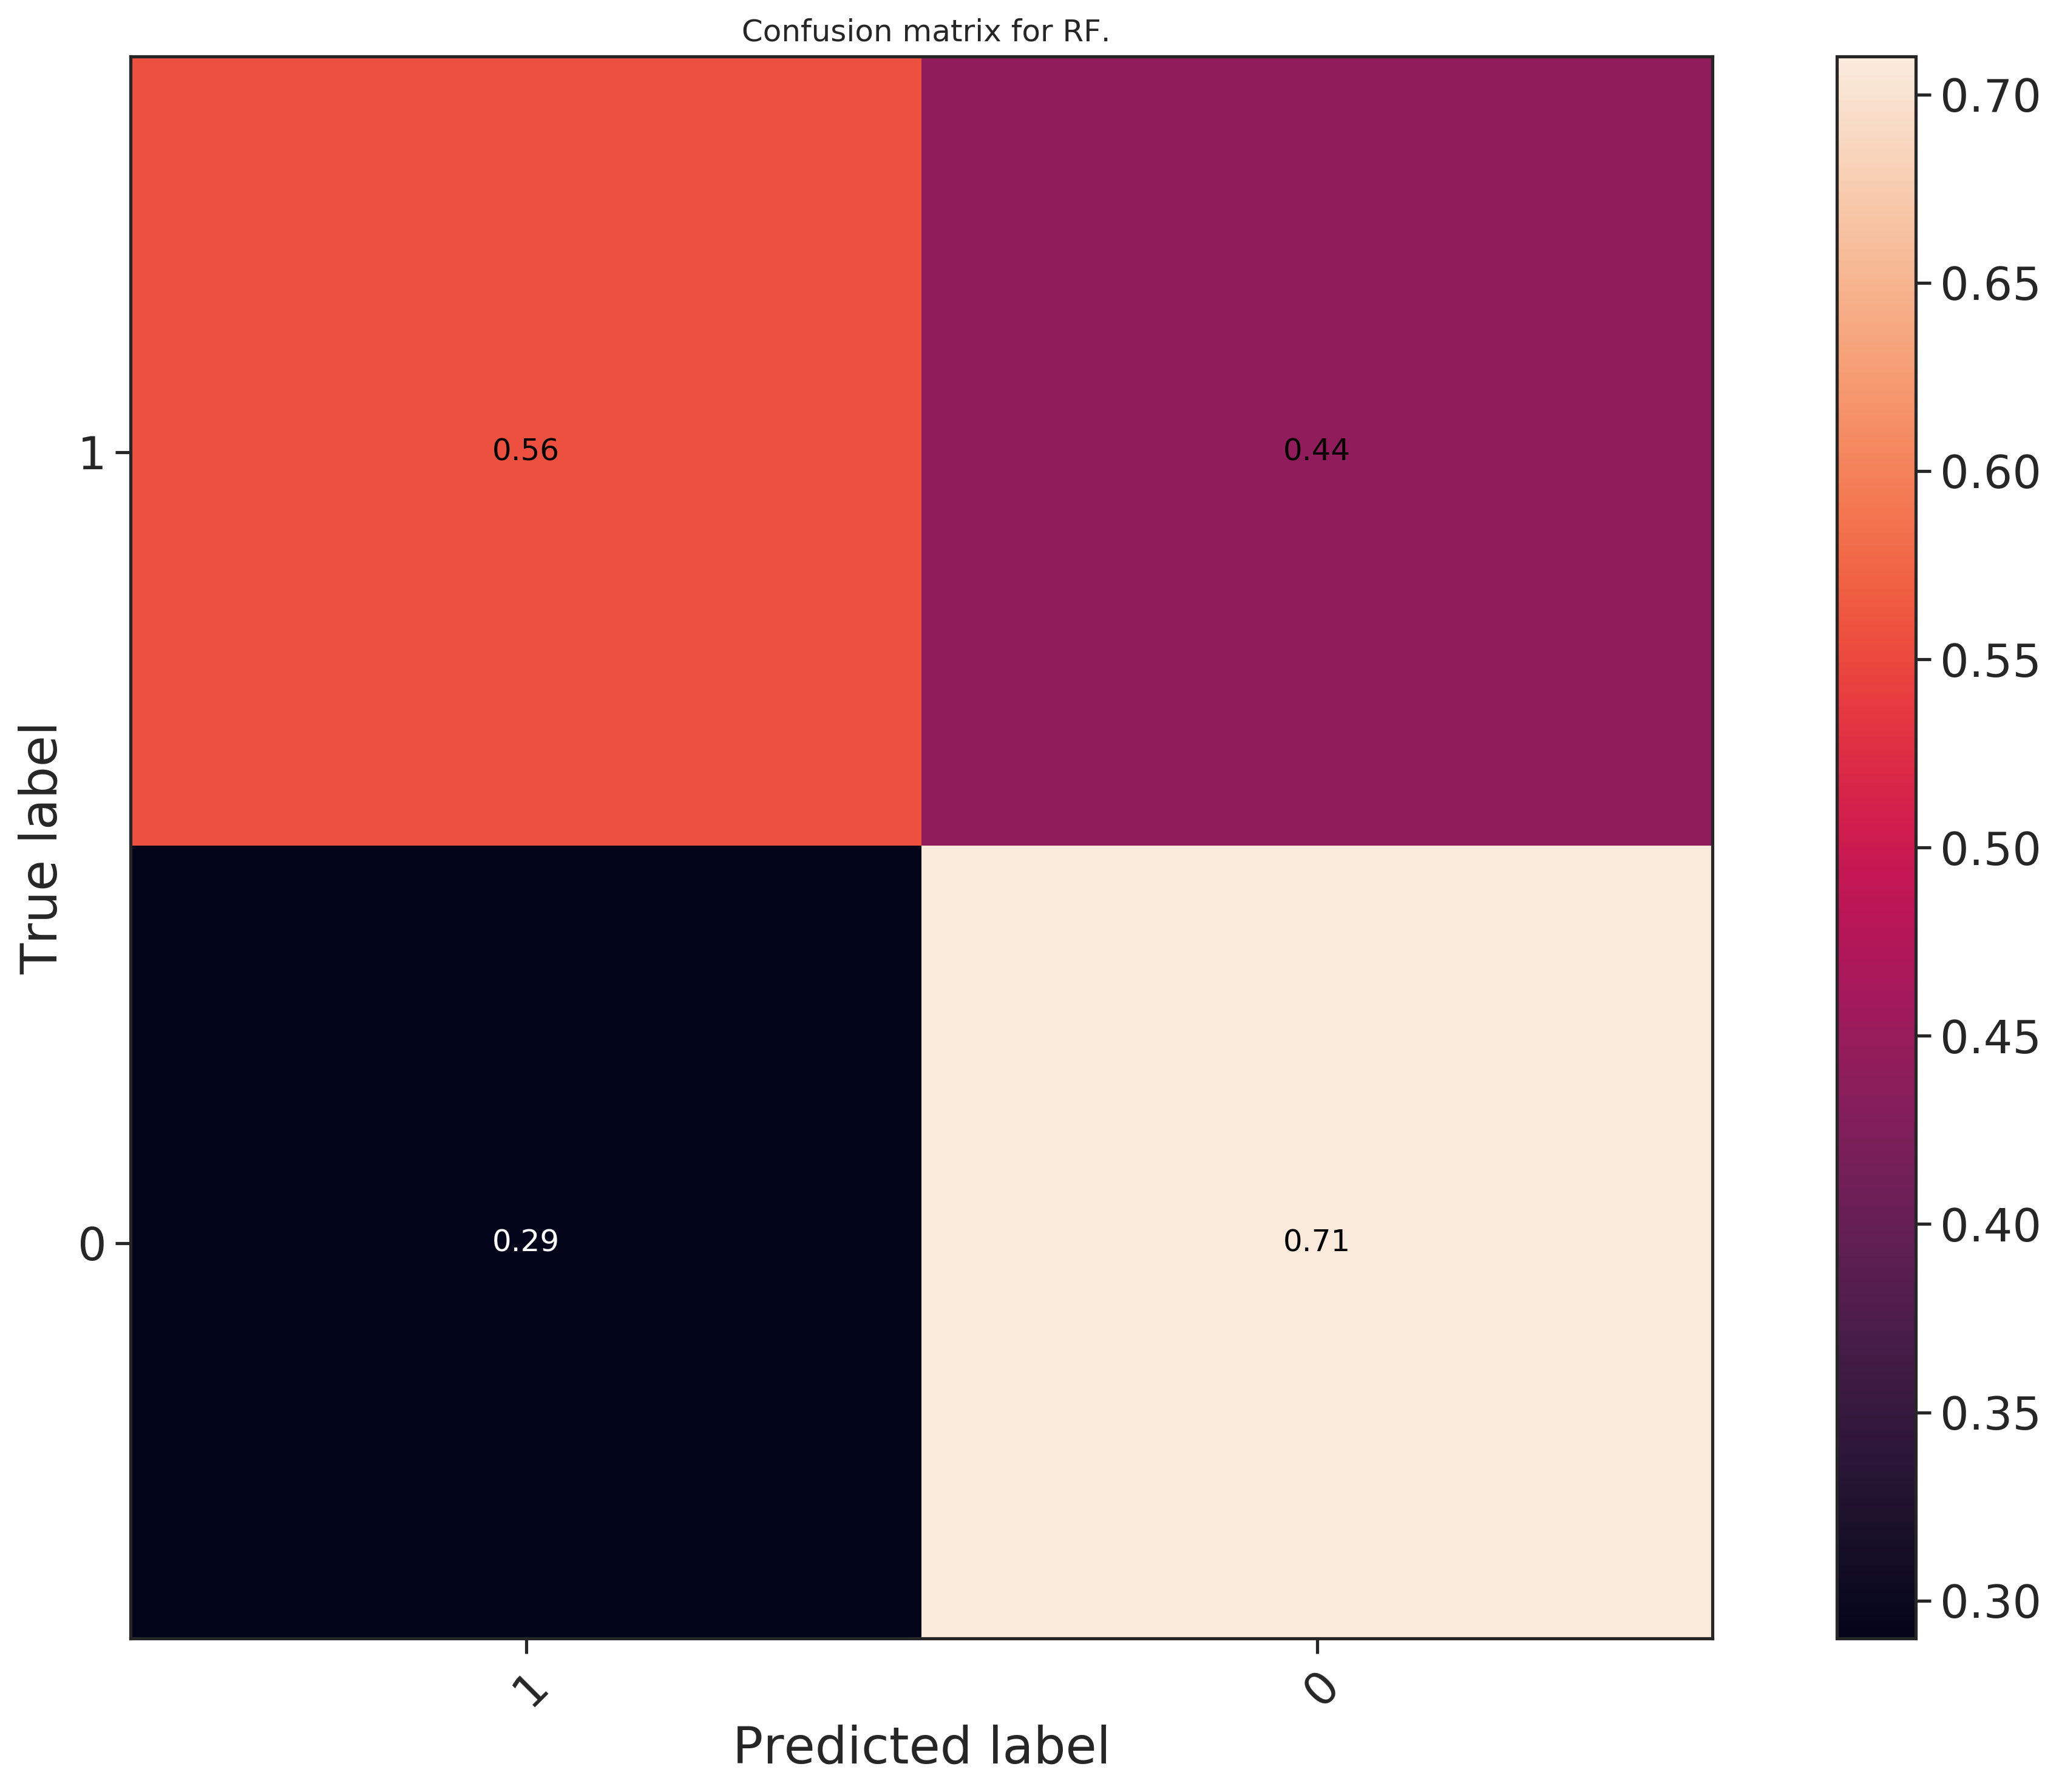

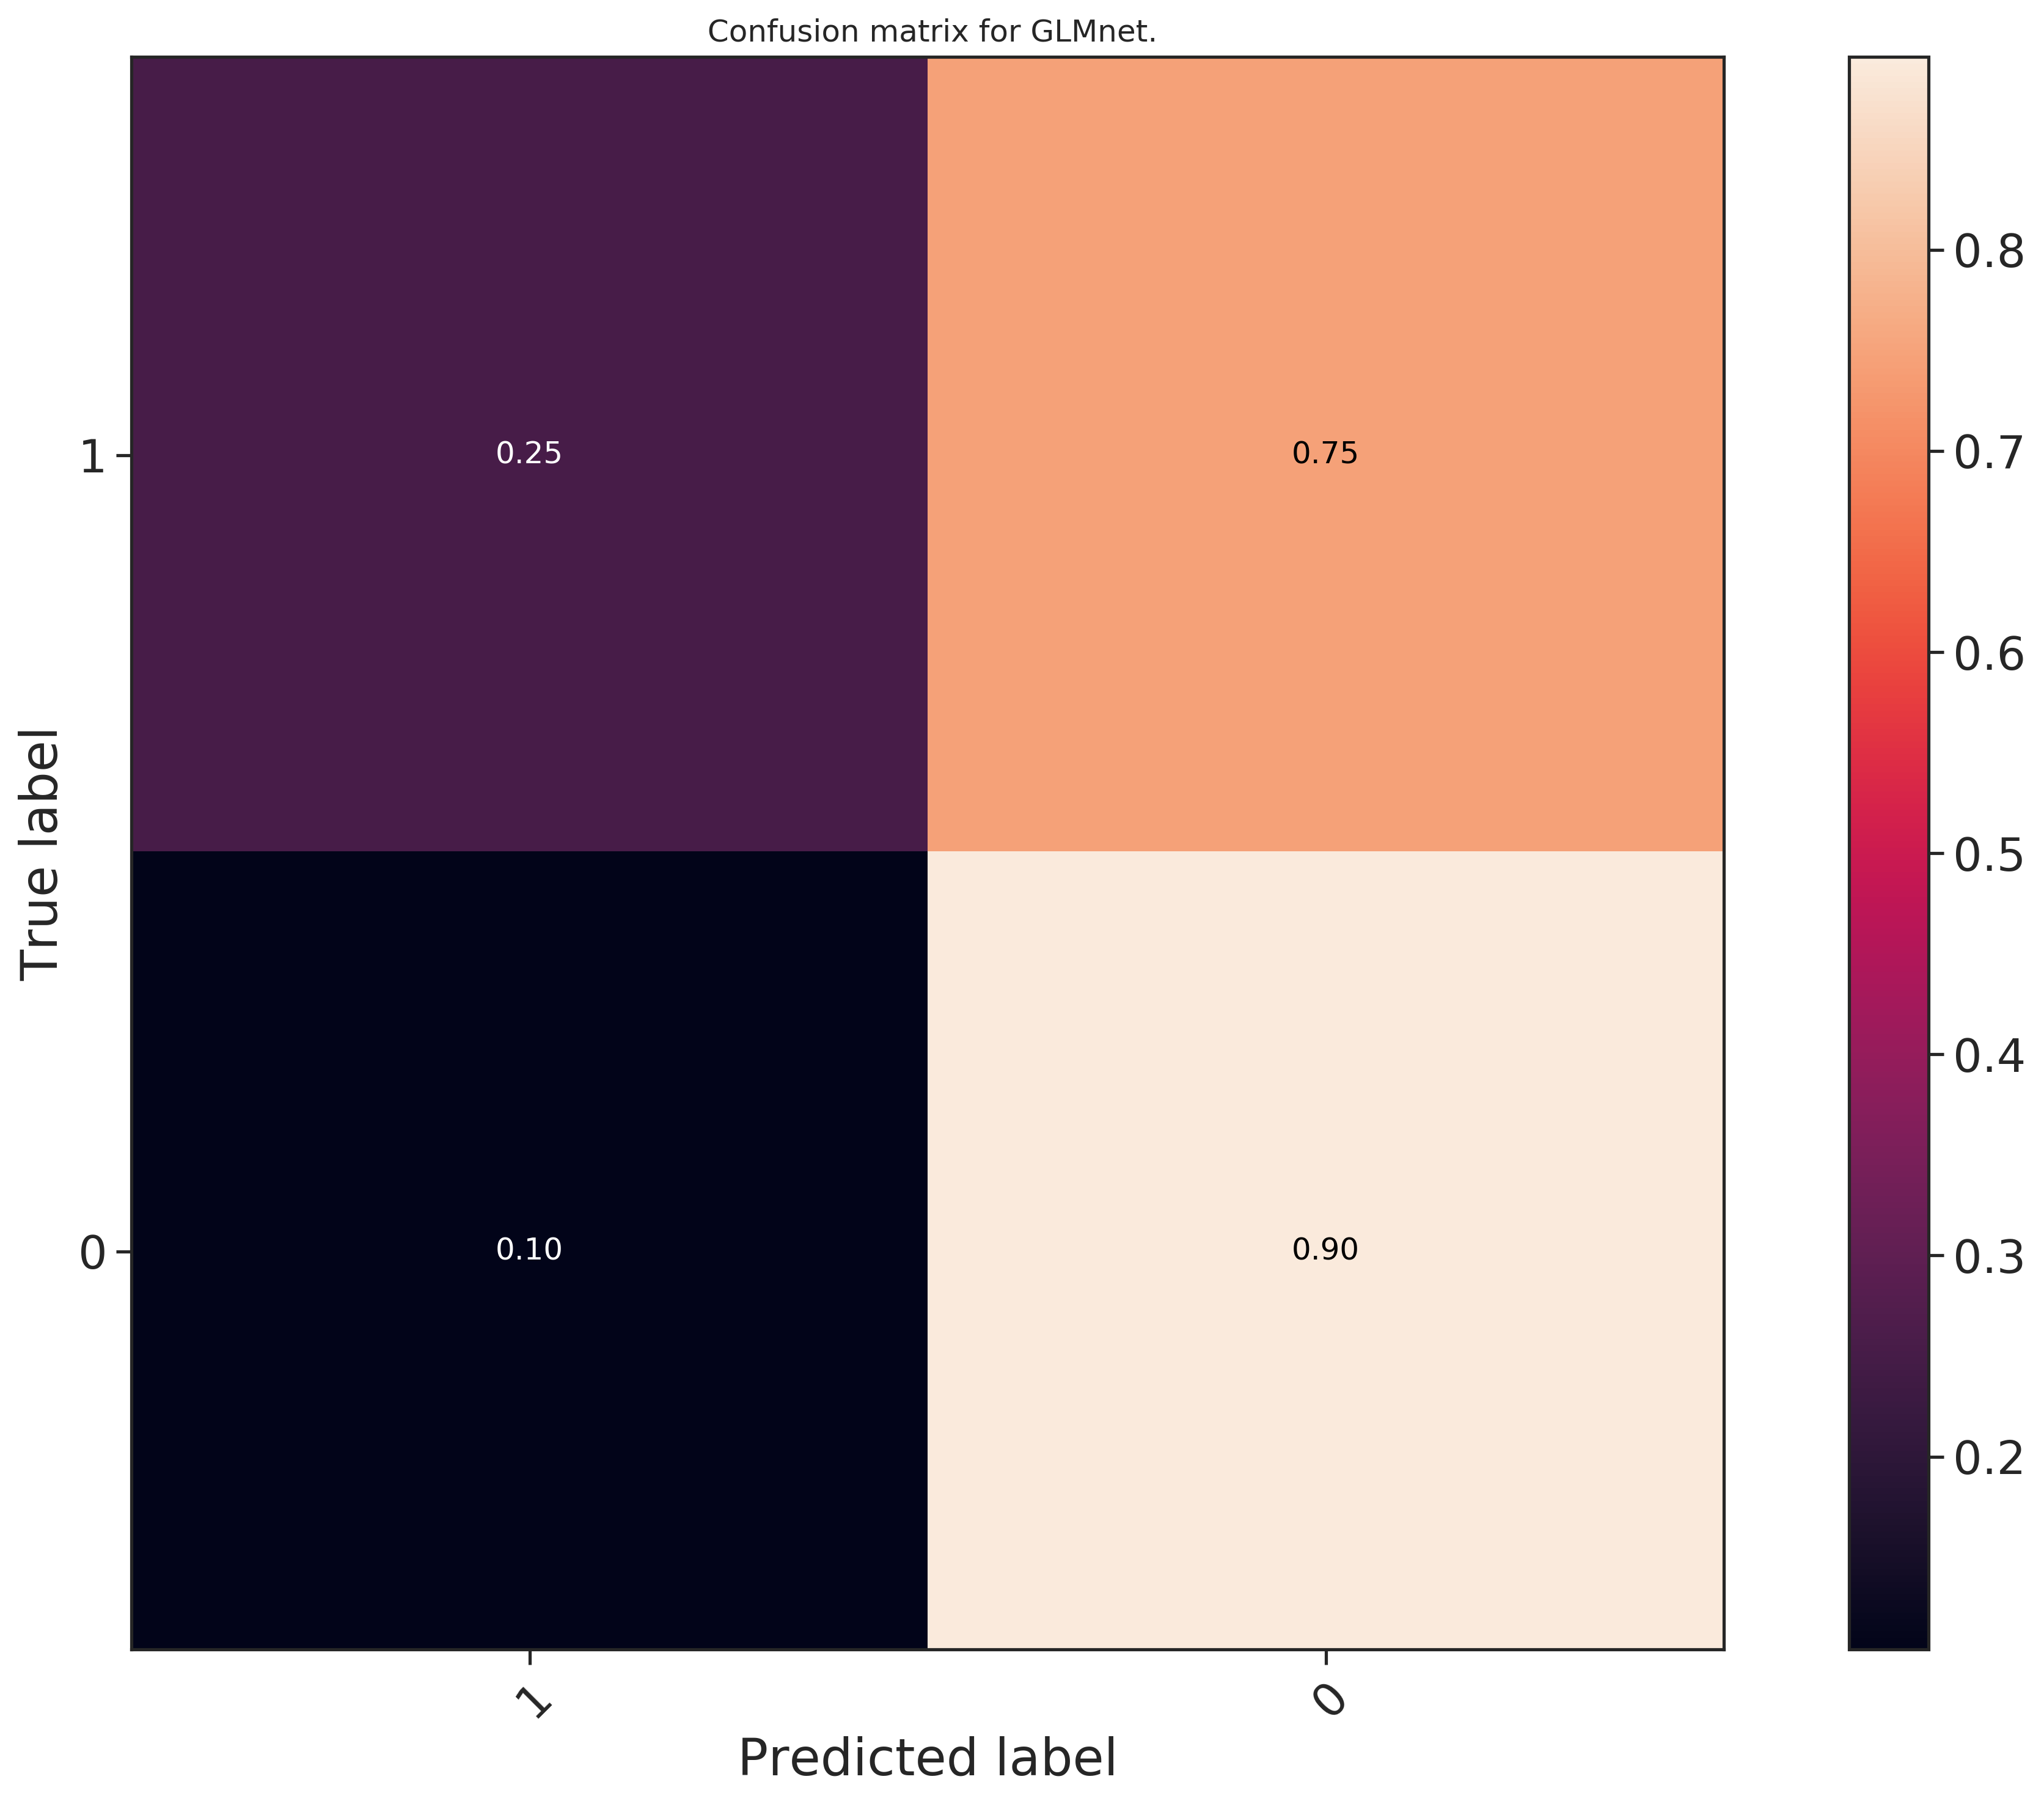

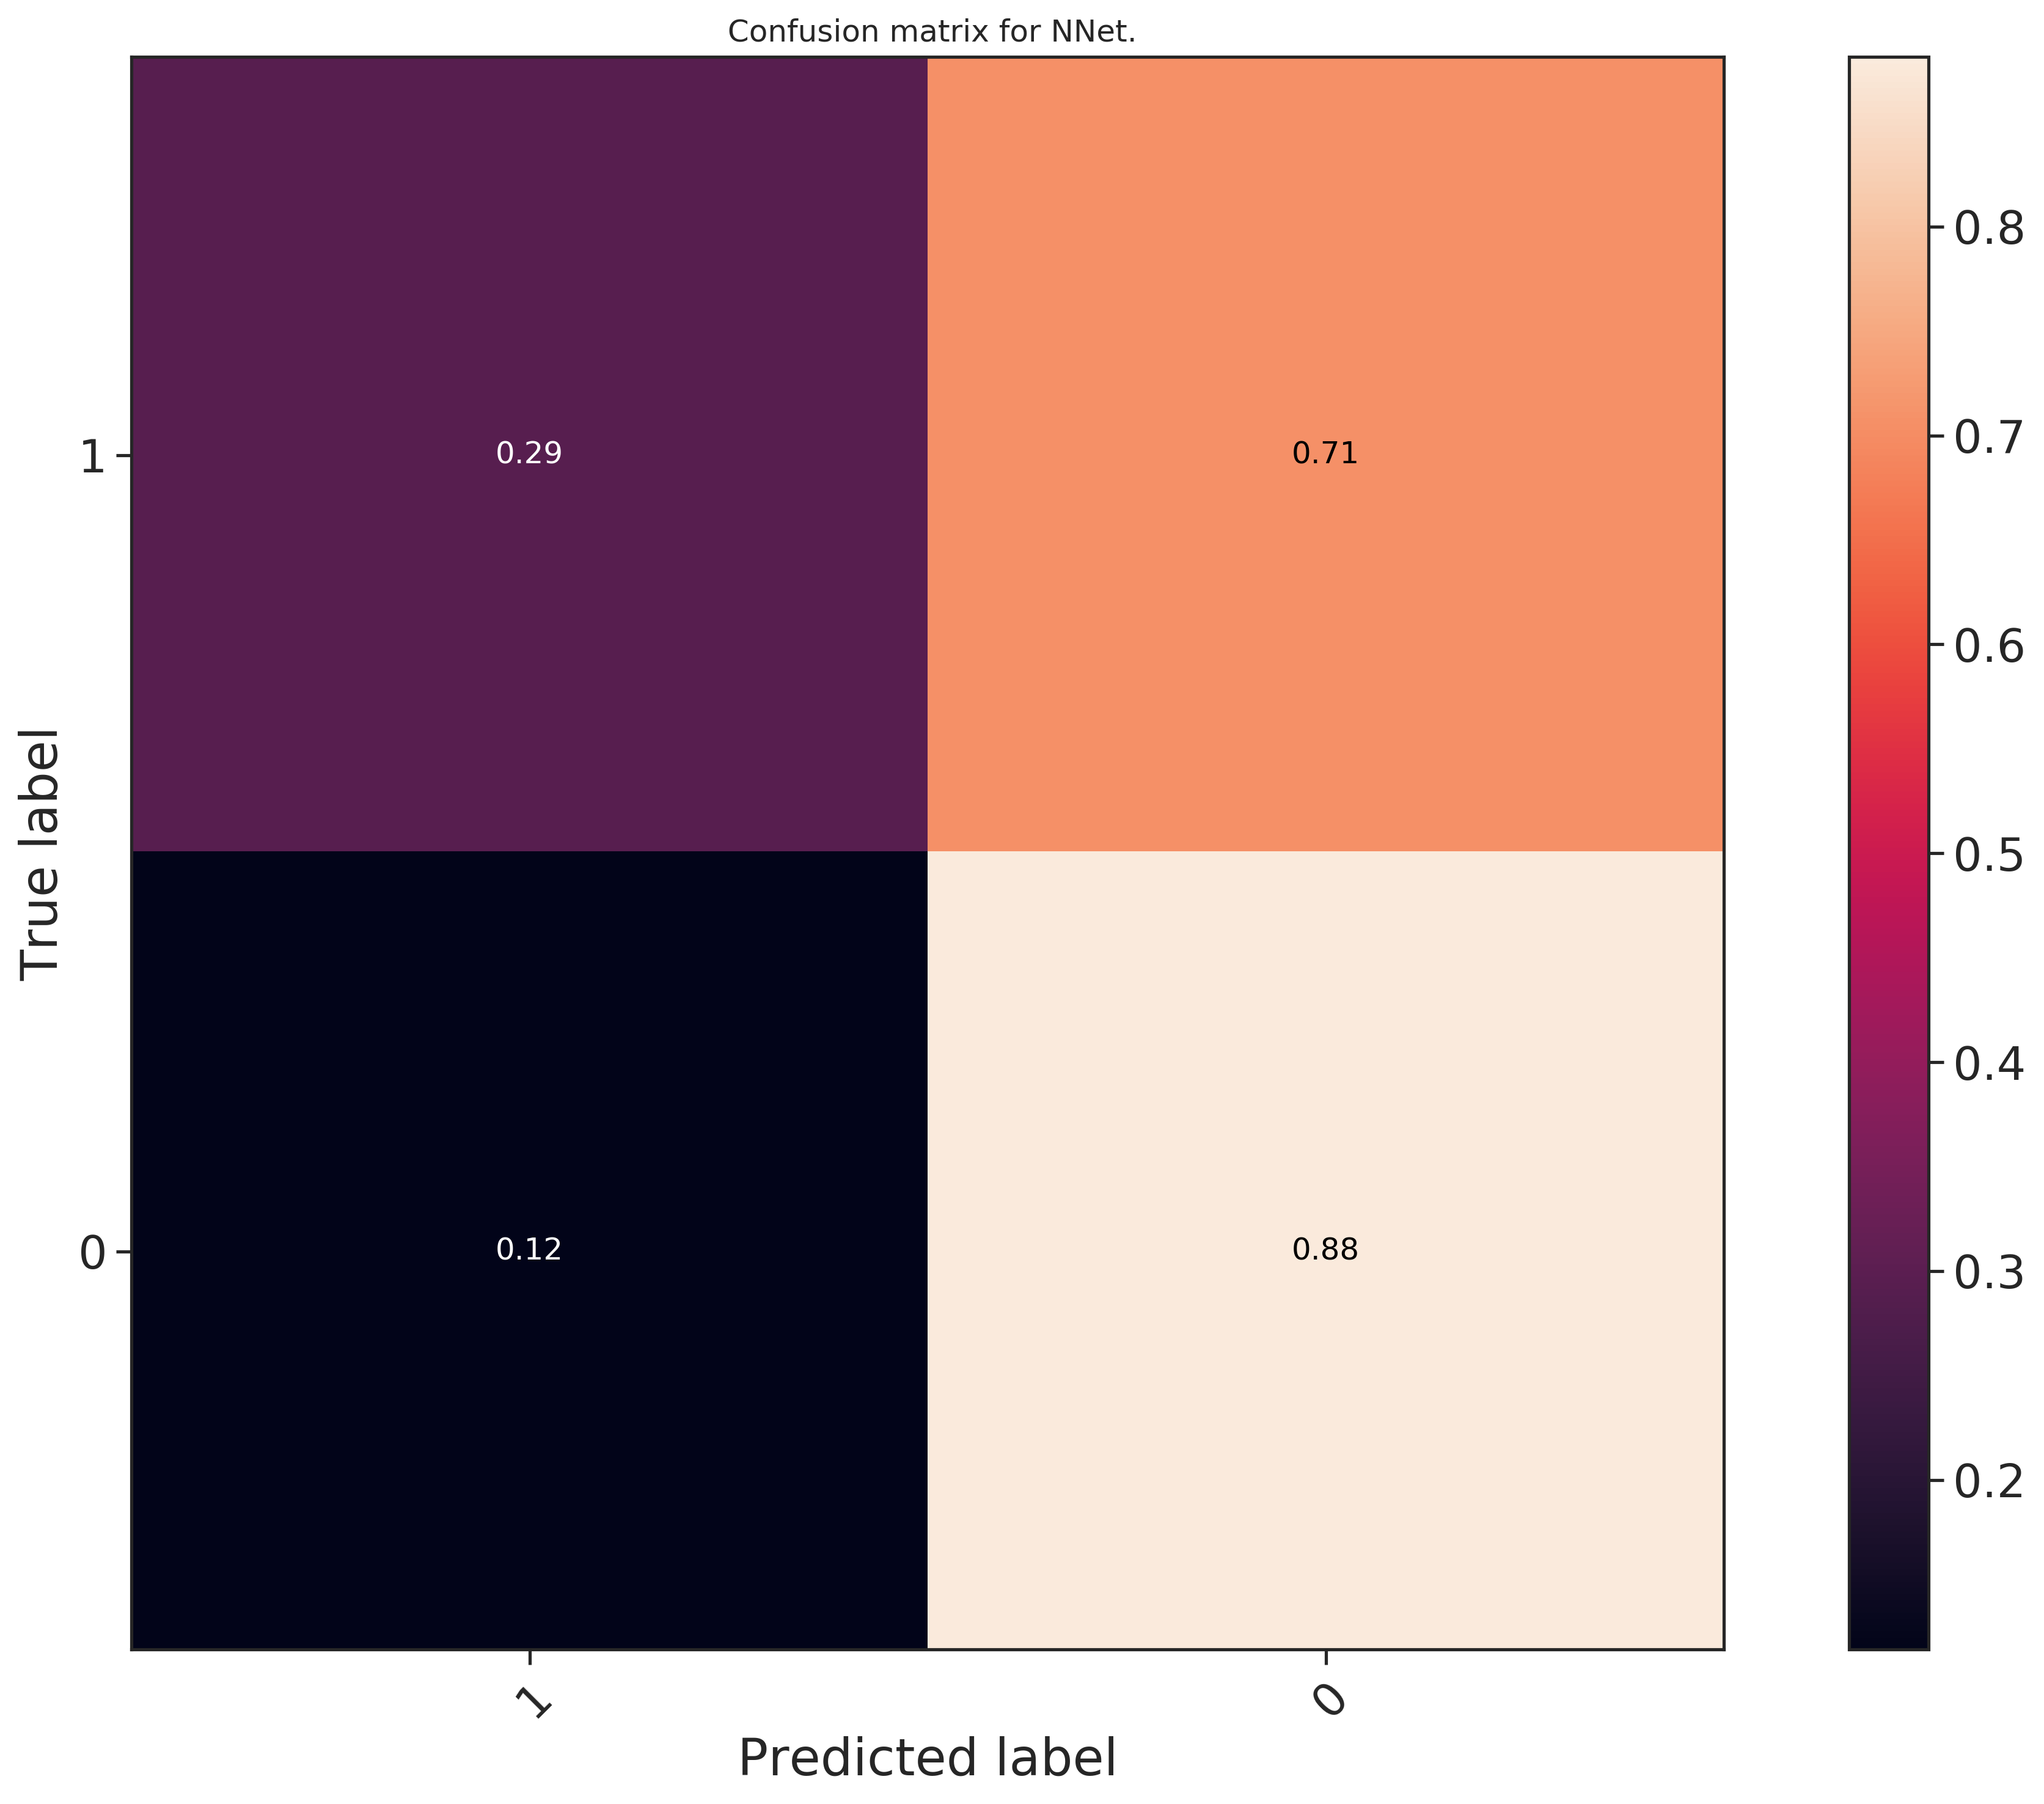

In [69]:
for m in gridsearch_results:
    if gridsearch_results[m]["best_estimator"]:
        y_predict = gridsearch_results[m]["best_estimator"].predict(X_test_all_relevant)
        gridsearch_results[m]["y_pred"] = y_predict
        plot_confusion_matrix(y_test,y_predict, [1,0], normalize=True, title=" Confusion matrix for {}.".format(m))
        save_fig("confusion_matrix_{}".format(m))

## ROC-AUC curve comparisons

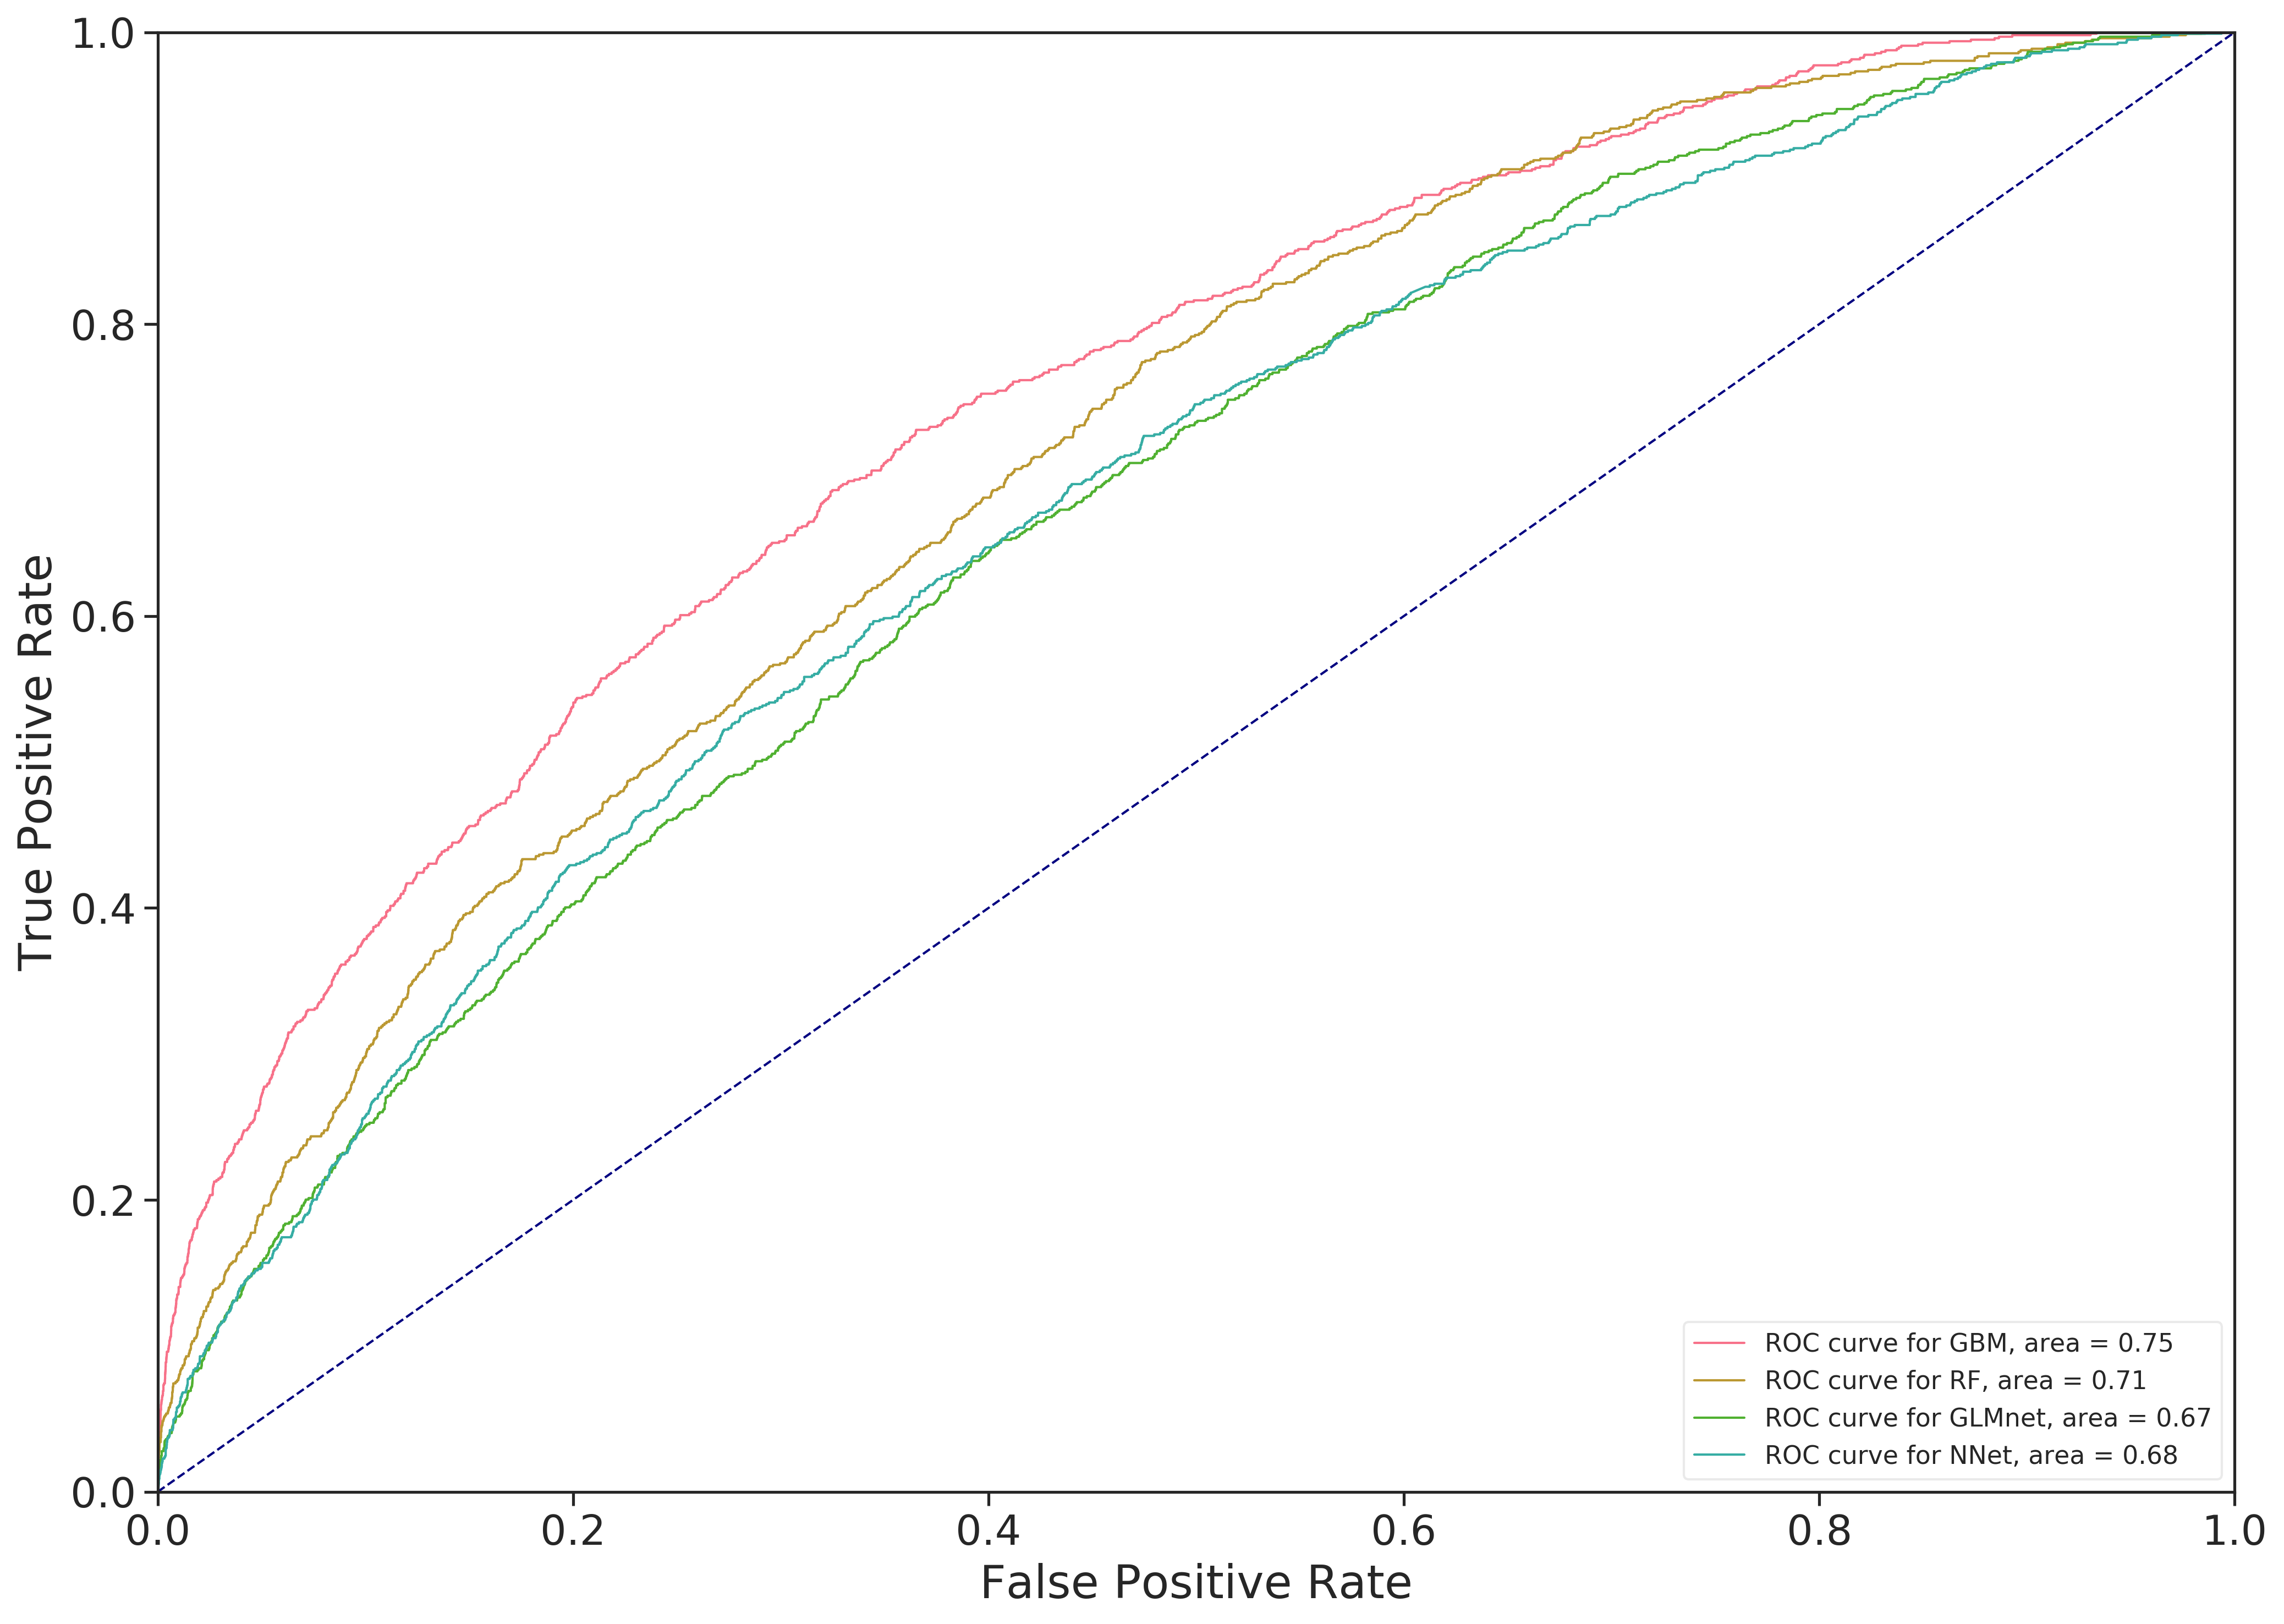

In [39]:
from sklearn.metrics import roc_curve, auc

def roc_curve_data(estimator):
    try:
        y_score = estimator.score(X_test_all_relevant)
    except Exception:
        y_score = estimator.predict_proba(X_test_all_relevant)[:,1]
        
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
    return (fpr, tpr, thresholds)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

for m in gridsearch_results:
    if gridsearch_results[m]["best_estimator"]:
        fpr, tpr, thresholds = roc_curve_data(gridsearch_results[m]["best_estimator"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label="ROC curve for {}, area = {:.2}".format(m, roc_auc))
plt.legend(loc="lower right")
save_fig("roc_auc_compared")

## XGBoost specific

In [ ]:
print(classification_report(y_test,y_predict_xgboost))

In [ ]:
plot_confusion_matrix(y_test, y_predict_xgboost, [1,0], normalize=True, cmap=Config.get("color_map"))

In [ ]:
eval_results_xgb = best_model_xgboost.evals_result()

epochs = len(eval_results_xgb['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, eval_results_xgb['validation_0']['logloss'], label='Train')
ax.plot(x_axis, eval_results_xgb['validation_1']['logloss'], label='Test')
logl_min = min(eval_results_xgb['validation_1']['logloss'])
logl_index = eval_results_xgb['validation_1']['logloss'].index(logl_min)
ax.plot((logl_index, logl_index), (0, logl_min), 'k-')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

## Random Forest specific

In [ ]:
best_model_rf.get_params()

In [ ]:
y_scores = best_model_rf.predict_proba(X_test_all_relevant)[:,1]

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [ ]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0., 1.01]);
    plt.xlim([0., 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [ ]:
precision_recall_threshold(p,r,thresholds, t=0.43)

In [ ]:
plot_precision_recall_vs_threshold(p,r,thresholds)

In [ ]:
kdd98_learn_feat_all_relevant.columns.values

In [ ]:
important_features_rf = best_estimator_rf.feature_importances_
important_features_rf = pd.DataFrame(data=important_features_rf, index=kdd98_learn_feat_all_relevant.columns.values, columns=["feature_importance"])

In [ ]:
important_features_rf = important_features_rf.sort_values(ascending=False, by="feature_importance")

In [ ]:
plt.rcParams['figure.figsize'] = (18, 10)
important_features_rf.head(n=40).sort_values(ascending=True, by="feature_importance").plot.barh()